# Ensemble Methods
The goal of **ensemble methods** is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

* In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

**Examples**: Bagging methods, Forests of randomized trees, …

* By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

**Examples**: AdaBoost, Gradient Tree Boosting, …

# Bagging Meta-Estimator

In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

Bagging methods come in many flavours but mostly differ from each other by the way they draw random subsets of the training set:

* When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting.
* When samples are drawn with replacement, then the method is known as Bagging.
* When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces.
* Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches.

In scikit-learn, bagging methods are offered as a unified BaggingClassifier meta-estimator (resp. BaggingRegressor), taking as input a user-specified base estimator along with parameters specifying the strategy to draw random subsets. In particular, max_samples and max_features control the size of the subsets (in terms of samples and features), while bootstrap and bootstrap_features control whether samples and features are drawn with or without replacement. When using a subset of the available samples the generalization accuracy can be estimated with the out-of-bag samples by setting oob_score=True. As an example, the snippet below illustrates how to instantiate a bagging ensemble of KNeighborsClassifier base estimators, each built on random subsets of 50% of the samples and 50% of the features.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier

# Forest of Randomized Trees
The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques [B1998] specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of size [n_samples, n_features] holding the training samples, and an array Y of size [n_samples] holding the target values (class labels) for the training samples:

# Random Forests
In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

In contrast to the original publication [B2001], the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.
# Extremly Randomized Trees 
In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

X, y = make_blobs(n_samples=10000, n_features=10, centers=100,
    random_state=0)

print(X.shape)
print(y.shape)
print('np.unique()')
print(np.unique(y))
print('len of unique y')
print(len(np.unique(y)))

# Homework use the classification report for each of the classifiers.
# what happens if you change from cross_val_score(...) and use instead clf.fit(x_train, y_train)
# clf.predict(x_test)?
# What happens when you try both cross_val_scor() and clf.fit() on the breast cancer data set?

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
    random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
print('Scores DecisionTreeClassifier:', scores.mean()) 


clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
print('Score RandomForestClassifier:', scores.mean())                               


clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)

print('Scores for ExtraTreeClassifier:', scores.mean())


(10000, 10)
(10000,)
np.unique()
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
len of unique y
100
Scores DecisionTreeClassifier: 0.9823000000000001
Score RandomForestClassifier: 0.9997
Scores for ExtraTreeClassifier: 1.0


# AdaBoost
The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire [FS1995].

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights , , …,  to each of the training samples. Initially, those weights are all set to , so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].



In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
print(iris.data.shape)
print(iris.target.shape)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores.mean()                             


(150, 4)
(150,)


0.9466666666666665

# Gradient Tree Boosting

Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

The advantages of GBRT are:

* Natural handling of data of mixed type (= heterogeneous features)
* Predictive power
* Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

* Scalability, due to the sequential nature of boosting it can hardly be parallelized.

The module sklearn.ensemble provides methods for both classification and regression via gradient boosted regression trees.

## Classification


GradientBoostingClassifier supports both binary and multi-class classification. The following example shows how to fit a gradient boosting classifier with 100 decision stumps as weak learners:

$\text{precision} = \frac{tp}{tp + fp},$

$\text{recall} = \frac{tp}{tp + fn},$

$F_\beta = (1 + \beta^2) \frac{\text{precision} \times \text{recall}}{\beta^2 \text{precision} + \text{recall}}.$

In [4]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix


X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

print(X_train.shape)
print(y_train.shape)

clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)    

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('Classification report for test data set:')
print(classification_report(y_test, y_pred))
print()
print('Classification report for train data set:')
print(classification_report(y_train, y_pred_train))

clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=1, random_state=0)


scores = cross_val_score(clf, X, y, cv=5)
print(round(scores.mean(), 2))
print(scores)

(2000, 10)
(2000,)
Classification report for test data set:
              precision    recall  f1-score   support

        -1.0       0.94      0.96      0.95      5049
         1.0       0.95      0.93      0.94      4951

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Classification report for train data set:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      1019
         1.0       1.00      1.00      1.00       981

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

0.87
[0.86838817 0.88004998 0.8675     0.88870363 0.86702793]


The number of weak learners (i.e. regression trees) is controlled by the parameter n_estimators; The size of each tree can be controlled either by setting the tree depth via max_depth or by setting the number of leaf nodes via max_leaf_nodes. The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage .

## Regression

GradientBoostingRegressor supports a number of different loss functions for regression which can be specified via the argument loss; the default loss function for regression is least squares ('ls').


In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))    


5.009154859960321

The figure below shows the results of applying GradientBoostingRegressor with least squares loss and 500 base learners to the Boston house price dataset (sklearn.datasets.load_boston). The plot on the left shows the train and test error at each iteration. The train error at each iteration is stored in the train_score_ attribute of the gradient boosting model. The test error at each iterations can be obtained via the staged_predict method which returns a generator that yields the predictions at each stage. Plots like these can be used to determine the optimal number of trees (i.e. n_estimators) by early stopping. The plot on the right shows the feature importances which can be obtained via the feature_importances_ property.

Both **GradientBoostingRegressor** and **GradientBoostingClassifier** support warm_start=True which allows you to add more estimators to an already fitted model.


GBRT

$F(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$

Similar to other boosting algorithms, GBRT builds the additive model in a greedy fashion:

$F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$,

where the newly added tree $h_m$ tries to minimize the loss $L$, given the previous ensemble $F_{m-1}$:

$h_m =  \arg\min_{h} \sum_{i=1}^{n} L(y_i,
F_{m-1}(x_i) + h(x_i)).$

Gradient Boosting attempts to solve this minimization problem numerically via steepest descent: The steepest descent direction is the negative gradient of the loss function evaluated at the current model  which can be calculated for any differentiable loss function:

$F_m(x) = F_{m-1}(x) - \gamma_m \sum_{i=1}^{n} \nabla_F L(y_i,
F_{m-1}(x_i))$

Where the step length $\gamma_m$ is chosen using line search:

$\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i)
- \gamma \frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)})$

The algorithms for regression and classification only differ in the concrete loss function used.

## Regularization
$F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)$

The parameter $\nu$ is also called the learning rate because it scales the step length the gradient descent procedure; it can be set via the learning_rate parameter.

## Voting Classifier

In [6]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

# Check feature selection
https://scikit-learn.org/stable/modules/feature_selection.html

In [7]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(150, 4)
(150, 3)


D:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
from sklearn import pipeline

clf = pipeline.Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())])


In [9]:
# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',
                          random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logi

## Voting Regressor

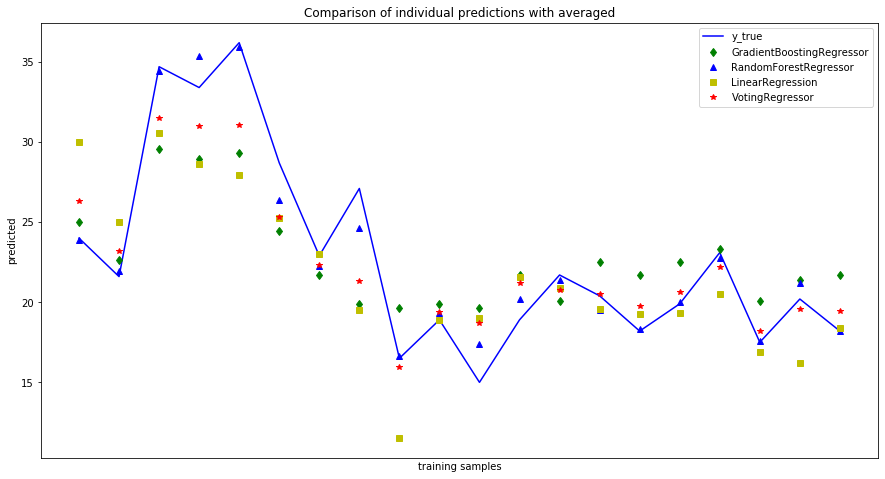

In [14]:
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Loading some example data
X, y = datasets.load_boston(return_X_y=True)

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)
ereg.fit(X, y)

xt = X[:20]

plt.figure(figsize=(15, 8))
plt.plot(y[:20], 'b', label='y_true')
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()